In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math


In [47]:
df = pd.read_csv("Macbook Air 13.csv")
df = df.drop(columns=['Unnamed: 0'])
df.head(2)

,stars,comments
0,4.0 stars,Okay. So you have been seeing people display...
1,5.0 stars,It's amazing..... battery last around 10 -12...


In [48]:
data = df.copy()
data['stars'] = data['stars'].str.replace('stars', "")
data['stars'] = data['stars'].astype(float)
data.head(2)

,stars,comments
0,4.0,Okay. So you have been seeing people display...
1,5.0,It's amazing..... battery last around 10 -12...


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
stars,2206.0,4.200363,1.403824,1.0,4.0,5.0,5.0,5.0


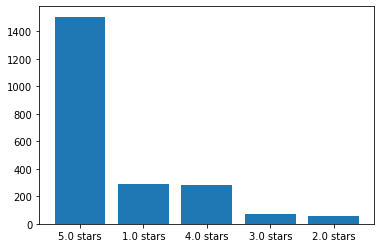

In [22]:
summarised_results = df["stars"].value_counts()
plt.bar(summarised_results.keys(), summarised_results.values)
plt.show()

### Stratified Shuffle Split to solve imbalanced data

In [69]:
from sklearn.model_selection import StratifiedShuffleSplit
print("Before {}".format(len(data)))
dataAfter = data.dropna(subset=["comments"])
# Removes all NAN in reviews.rating
print("After {}".format(len(dataAfter)))

Before 2206
After 2204


In [70]:
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
for train_index, test_index in split.split(dataAfter,dataAfter["stars"]): 
    strat_train = dataAfter.reindex(train_index)
    strat_test = dataAfter.reindex(test_index)

In [51]:
len(strat_train)

1763

In [12]:
strat_train["stars"].value_counts()/len(strat_train)

5.0    0.680091
1.0    0.132728
4.0    0.127623
3.0    0.030062
2.0    0.028361
Name: stars, dtype: float64

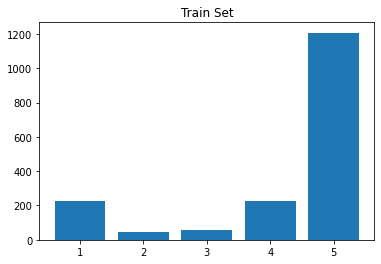

In [34]:
summarised_results = strat_train["stars"].value_counts()
plt.bar(summarised_results.keys(), summarised_results.values)
plt.title("Train Set")
plt.show()

In [52]:
len(strat_test["stars"])

441

In [15]:
strat_test["stars"].value_counts()/len(strat_test)

5.0    0.684807
1.0    0.129252
4.0    0.124717
3.0    0.038549
2.0    0.022676
Name: stars, dtype: float64

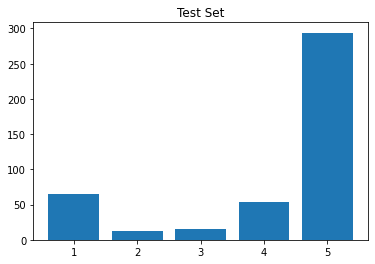

In [35]:
summarised_results = strat_test["stars"].value_counts()
plt.bar(summarised_results.keys(), summarised_results.values)
plt.title("Test Set")
plt.show()

### Sentiment Analysis

In [7]:
def sentiments(rating):
    if (rating == 5) or (rating == 4):
        return "Positive"
    elif rating == 3:
        return "Neutral"
    elif (rating == 2) or (rating == 1):
        return "Negative"

In [71]:
strat_train.shape

(1763, 2)

In [72]:
strat_train = strat_train.dropna()
strat_train.shape

(1762, 2)

In [73]:
strat_test = strat_test.dropna()
strat_test.shape

(440, 2)

In [74]:
strat_train["Sentiment"] = strat_train["stars"].apply(sentiments)
strat_test["Sentiment"] = strat_test["stars"].apply(sentiments)
strat_train["Sentiment"][:5]

516     Positive
1714    Negative
1721    Positive
262      Neutral
471     Positive
Name: Sentiment, dtype: object

In [75]:
strat_test["Sentiment"].unique()

array(['Positive', 'Negative', 'Neutral'], dtype=object)

In [76]:
# Prepare data
X_train = strat_train["comments"]
y_train = strat_train["Sentiment"]
X_test = strat_test["comments"]
y_test = strat_test["Sentiment"]
print(len(X_train), len(X_test))

1762 440


####  Extract Features

In [77]:
X_train.isnull().values.any()

False

In [78]:
# Text preprocessing and occurance counting
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction import stop_words
import nltk
from nltk.tokenize import TweetTokenizer
np.random.seed(7)

def tokenize(text): 
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)

en_stopwords = stop_words.ENGLISH_STOP_WORDS
# vectorizer = CountVectorizer(
#     analyzer = 'word',
#     tokenizer = tokenize,
#     lowercase = True,
#     stop_words = en_stopwords)
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train) 
X_train_counts.shape
#1763 training samples and 6009 distinct words in our training sample.

(1762, 5331)

In [79]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer(use_idf=False)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(1762, 5331)

In [29]:
X_train_tfidf

<1761x5324 sparse matrix of type '<class 'numpy.float64'>'
	with 46176 stored elements in Compressed Sparse Row format>

### Multinominal Naive Bayes Classifier

In [80]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
clf_multiNB_pipe = Pipeline([("vect", CountVectorizer()), 
                             ("tfidf", TfidfTransformer()),
                             ("clf_nominalNB", MultinomialNB())])
clf_multiNB_pipe.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf_nominalNB', MultinomialNB())])

In [81]:
predictedMultiNB = clf_multiNB_pipe.predict(X_test)
np.mean(predictedMultiNB == y_test)

0.8136363636363636

In [82]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(y_test,  predictedMultiNB))
print('Accuracy: {}'. format(accuracy_score(y_test, predictedMultiNB)))

              precision    recall  f1-score   support

    Negative       1.00      0.01      0.03        70
     Neutral       0.00      0.00      0.00        13
    Positive       0.81      1.00      0.90       357

    accuracy                           0.81       440
   macro avg       0.60      0.34      0.31       440
weighted avg       0.82      0.81      0.73       440

Accuracy: 0.8136363636363636


v:\d drive\program files\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Logistic Regression Classifier

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
clf_logReg_pipe = Pipeline([("vect", CountVectorizer()), 
                            ("tfidf", TfidfTransformer()), 
                            ("clf_logReg", LogisticRegression())])
clf_logReg_pipe.fit(X_train, y_train)

import numpy as np
predictedLogReg = clf_logReg_pipe.predict(X_test)
np.mean(predictedLogReg == y_test)

0.9045454545454545

In [84]:
print(classification_report(y_test,  predictedLogReg))
print('Accuracy: {}'. format(accuracy_score(y_test, predictedLogReg)))

              precision    recall  f1-score   support

    Negative       0.88      0.64      0.74        70
     Neutral       0.00      0.00      0.00        13
    Positive       0.91      0.99      0.95       357

    accuracy                           0.90       440
   macro avg       0.60      0.54      0.56       440
weighted avg       0.88      0.90      0.89       440

Accuracy: 0.9045454545454545


v:\d drive\program files\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Support Vector Machine CLassifier

In [85]:
from sklearn.svm import LinearSVC
clf_linearSVC_pipe = Pipeline([("vect", CountVectorizer()), 
                               ("tfidf", TfidfTransformer()),
                               ("clf_linearSVC", LinearSVC())])
clf_linearSVC_pipe.fit(X_train, y_train)

predictedLinearSVC = clf_linearSVC_pipe.predict(X_test)
np.mean(predictedLinearSVC == y_test)

0.9022727272727272

In [86]:
print(classification_report(y_test,  predictedLinearSVC))
print('Accuracy: {}'. format(accuracy_score(y_test, predictedLinearSVC)))

              precision    recall  f1-score   support

    Negative       0.80      0.73      0.76        70
     Neutral       0.00      0.00      0.00        13
    Positive       0.92      0.97      0.95       357

    accuracy                           0.90       440
   macro avg       0.57      0.57      0.57       440
weighted avg       0.88      0.90      0.89       440

Accuracy: 0.9022727272727272


### Decision Tree Classifier

In [38]:
from sklearn.tree import DecisionTreeClassifier
clf_decisionTree_pipe = Pipeline([("vect", CountVectorizer()), 
                                  ("tfidf", TfidfTransformer()), 
                                  ("clf_decisionTree", DecisionTreeClassifier())
                                 ])
clf_decisionTree_pipe.fit(X_train, y_train)

predictedDecisionTree = clf_decisionTree_pipe.predict(X_test)
np.mean(predictedDecisionTree == y_test)

0.7959183673469388

In [39]:
print(classification_report(y_test,  predictedDecisionTree))
print('Accuracy: {}'. format(accuracy_score(y_test, predictedDecisionTree)))

              precision    recall  f1-score   support

    Negative       0.50      0.45      0.47        67
     Neutral       0.00      0.00      0.00        17
    Positive       0.86      0.90      0.88       357

    accuracy                           0.80       441
   macro avg       0.45      0.45      0.45       441
weighted avg       0.77      0.80      0.78       441

Accuracy: 0.7959183673469388


### Random Forest Classifier

In [40]:
from sklearn.ensemble import RandomForestClassifier
clf_randomForest_pipe = Pipeline([("vect", CountVectorizer()), 
                                  ("tfidf", TfidfTransformer()), 
                                  ("clf_randomForest", RandomForestClassifier())
                                 ])
clf_randomForest_pipe.fit(X_train, y_train)

predictedRandomForest = clf_randomForest_pipe.predict(X_test)
np.mean(predictedRandomForest == y_test)

0.8571428571428571

In [42]:
print(classification_report(y_test,  predictedRandomForest))
print('Accuracy: {}'. format(accuracy_score(y_test, predictedRandomForest)))

              precision    recall  f1-score   support

    Negative       0.88      0.42      0.57        67
     Neutral       0.00      0.00      0.00        17
    Positive       0.86      0.98      0.92       357

    accuracy                           0.86       441
   macro avg       0.58      0.47      0.49       441
weighted avg       0.83      0.86      0.83       441

Accuracy: 0.8571428571428571


### Experiments on SVM Classifier

In [59]:
predictedLinearSVC[:5]

array(['Negative', 'Positive', 'Positive', 'Negative', 'Negative'],
      dtype=object)

In [60]:
X_test[:5]

1725                      Stopped working after 3 months.
2003                            Best laptops in the world
369          Beautiful laptop very light weight and fast.
16        Bought this MacBook for 51K in 2018 and 2 we...
377       I have received a defective product, the dis...
Name: comments, dtype: object

In [87]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],    
             'tfidf__use_idf': (True, False), } 
SVM_Grid = GridSearchCV(clf_linearSVC_pipe, parameters, n_jobs=-1)
Best_SVM_Pred = SVM_Grid.fit(X_train, y_train)


In [88]:
Best_SVM_Pred.best_params_

{'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

In [89]:
Best_SVM_Pred.cv_results_

{'mean_fit_time': array([0.0937489 , 0.26529021, 0.52000804, 0.0869669 , 0.25172486,
        0.43483553]),
 'std_fit_time': array([0.00209199, 0.01049783, 0.01131034, 0.01199153, 0.00635774,
        0.01750314]),
 'mean_score_time': array([0.01655598, 0.03211436, 0.04787111, 0.01515965, 0.02952108,
        0.02832398]),
 'std_score_time': array([0.00079862, 0.00347809, 0.00383606, 0.00132248, 0.00149181,
        0.00470415]),
 'param_tfidf__use_idf': masked_array(data=[True, True, True, False, False, False],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_vect__ngram_range': masked_array(data=[(1, 1), (1, 2), (1, 3), (1, 1), (1, 2), (1, 3)],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)},
  {'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)},
  {'tfidf__use_idf': True, 'vect__ng

In [53]:
Best_SVM_Pred.best_score_

0.9028988539788824

In [90]:
new_text = ["The tablet is good, really liked it.", # positive
            "The tablet is ok, but it works fine.", # neutral
            "The tablet is not good, does not work very well."] # negative

y_pred = Best_SVM_Pred.predict(new_text)

In [91]:
y_pred

array(['Positive', 'Positive', 'Negative'], dtype=object)

In [92]:
predictedGS_clf_LinearSVC_pipe = Best_SVM_Pred.predict(X_test)
np.mean(predictedGS_clf_LinearSVC_pipe == y_test)

0.9113636363636364

In [94]:
for performance_analysis in (Best_SVM_Pred.best_score_, 
                             Best_SVM_Pred.best_estimator_, 
                             Best_SVM_Pred.best_params_):
        print(performance_analysis)

0.895573654390935
Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()), ('clf_linearSVC', LinearSVC())])
{'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}


In [96]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(y_test, 
                            predictedGS_clf_LinearSVC_pipe))
print('Accuracy: {}'. format(accuracy_score(y_test, 
                             predictedGS_clf_LinearSVC_pipe)))

              precision    recall  f1-score   support

    Negative       0.88      0.70      0.78        70
     Neutral       0.00      0.00      0.00        13
    Positive       0.92      0.99      0.95       357

    accuracy                           0.91       440
   macro avg       0.60      0.56      0.58       440
weighted avg       0.88      0.91      0.89       440

Accuracy: 0.9113636363636364


v:\d drive\program files\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
X_train_targetSentiment.head(2)

1305    Negative
1964    Positive
Name: Sentiment, dtype: object

In [129]:
from sklearn import metrics
metrics.confusion_matrix(X_test_targetSentiment,
                         predictedGS_clf_LinearSVC_pipe)

array([[ 53,   0,  25],
       [  2,   0,  13],
       [  7,   0, 340]], dtype=int64)

Confusion matrix, without normalization
[[ 49   0  21]
 [  2   0  11]
 [  5   0 352]]
Normalized confusion matrix
[[0.7        0.         0.3       ]
 [0.15384615 0.         0.84615385]
 [0.0140056  0.         0.9859944 ]]


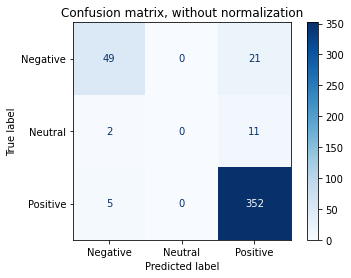

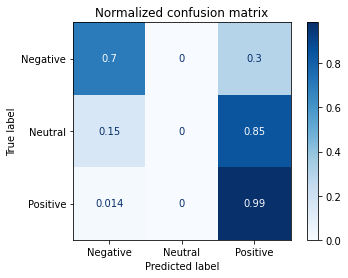

In [103]:
from sklearn.metrics import plot_confusion_matrix

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
labels = ['Negative', 'Neutral', 'Positive']
for title, normalize in titles_options:
    disp = plot_confusion_matrix(Best_SVM_Pred, X_test, y_test,
                                 display_labels=labels,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [109]:
y_pred = Best_SVM_Pred.predict(X_test)

In [111]:
print(classification_report(y_pred,  y_test))
print('Accuracy: {}'. format(accuracy_score(y_pred, y_test)))

              precision    recall  f1-score   support

    Negative       0.70      0.88      0.78        56
     Neutral       0.00      0.00      0.00         0
    Positive       0.99      0.92      0.95       384

    accuracy                           0.91       440
   macro avg       0.56      0.60      0.58       440
weighted avg       0.95      0.91      0.93       440

Accuracy: 0.9113636363636364


In [97]:
df = pd.read_csv("Surface Pro 7.csv")
df = df.drop(columns=['Unnamed: 0'])
data = df.copy()
data['stars'] = data['stars'].str.replace('stars', "")
data['stars'] = data['stars'].astype(float)
data.head(2)

,stars,comments
0,4.0,"Pros:• USB-C, Finally! As a past Surface Pro..."
1,2.0,"Comparing Dell XPS 13, Lenovo Yoga C940 14 a..."


In [106]:
data.shape

(273, 3)

In [98]:
y_pred = Best_SVM_Pred.predict(data['comments'])

In [99]:
data["Sentiment"] = data["stars"].apply(sentiments)
np.mean(y_pred == data['Sentiment'])

0.73992673992674

In [108]:
print(classification_report(y_pred,  data['Sentiment']))
print('Accuracy: {}'. format(accuracy_score(y_pred, data['Sentiment'])))

              precision    recall  f1-score   support

    Negative       0.46      0.82      0.59        51
     Neutral       0.00      0.00      0.00         0
    Positive       0.98      0.72      0.83       222

    accuracy                           0.74       273
   macro avg       0.48      0.51      0.47       273
weighted avg       0.88      0.74      0.79       273

Accuracy: 0.73992673992674


v:\d drive\program files\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [105]:
comments =  data['comments'][:5]
sentiments = y_pred[:5]
result = pd.DataFrame({'comments': comments, 'sentiments':sentiments})
result

,comments,sentiments
0,"Pros:• USB-C, Finally! As a past Surface Pro...",Positive
1,"Comparing Dell XPS 13, Lenovo Yoga C940 14 a...",Positive
2,I'm seeing complaints about how this isn't a...,Positive
3,Purchased this item trying to make sure I go...,Positive
4,"Is not a surface pro 7, is not intel core i5...",Negative


Confusion matrix, without normalization
[[ 42   0  49]
 [  6   0  13]
 [  3   0 160]]
Normalized confusion matrix
[[0.46153846 0.         0.53846154]
 [0.31578947 0.         0.68421053]
 [0.01840491 0.         0.98159509]]


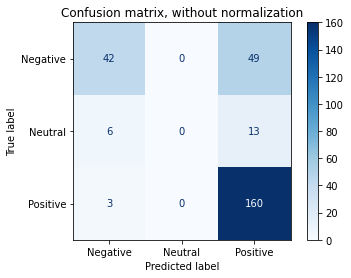

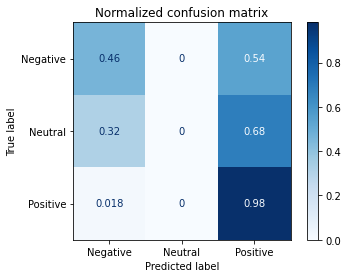

In [107]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
labels = ['Negative', 'Neutral', 'Positive']
for title, normalize in titles_options:
    disp = plot_confusion_matrix(Best_SVM_Pred, data['comments'], data['Sentiment'],
                                 display_labels=labels,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()